# **Import Libraries**

In [ ]:
import pandas as pd
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Load Dataset**

In [ ]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/cyberbullying_tweets.csv')

Mounted at /content/drive


# **EDA (Exploratory Data Analysis)**

In [ ]:
# Informasi 5 baris pertama
print(df.head())

                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


In [ ]:
# Informasi kolom
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB
None


In [ ]:
# Missing Values
print(df.isnull().sum())

tweet_text            0
cyberbullying_type    0
dtype: int64


In [ ]:
# Informasi panjang teks
df['text_length'] = df['tweet_text'].astype(str).apply(len)
print("Rata-rata panjang tweet:", df['text_length'].mean())
print("Panjang tweet terpendek:", df['text_length'].min())
print("Panjang tweet terpanjang:", df['text_length'].max())

Rata-rata panjang tweet: 136.25322905309068
Panjang tweet terpendek: 1
Panjang tweet terpanjang: 5018


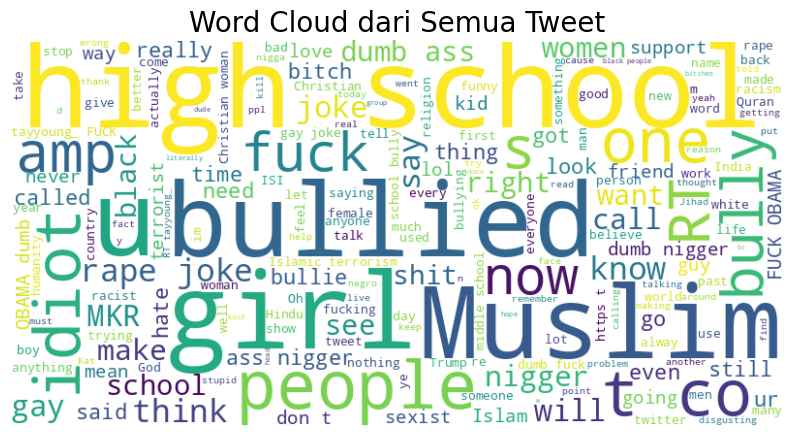

In [ ]:
# Word Cloud dari tweet_text
text_all = ' '.join(df['tweet_text'].dropna().astype(str).values)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_all)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dari Semua Tweet", fontsize=20)
plt.show()

In [ ]:
# Cek Unique Values dalam kolom cyberbullying_type
print("Kelas unik dalam kolom:", df['cyberbullying_type'].unique())

Kelas unik dalam kolom: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']


In [ ]:
# Distribusi kelas
class_dist = df['cyberbullying_type'].value_counts(dropna=False)
print('Distribusi kelas:', class_dist)

Distribusi kelas: cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


In [ ]:
# Kelas mayoritas dan kelas minoritas
print("Kelas mayoritas:", class_dist.idxmax())
print("Kelas minoritas:", class_dist.idxmin())

Kelas mayoritas: religion
Kelas minoritas: other_cyberbullying


# **Preprocessing**

In [ ]:
# Bersihkan teks
def clean_text(text):
    # Memastikan input adalah string sebelum preprocessing
    if not isinstance(text, str):
        return ""  # Or handle non-string values as appropriate jika

    # 1. Hapus URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 2. Hapus mentions (@username) dan hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # 3. Hapus angka dan karakter khusus
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 4. Convert to lowercase
    text = text.lower()

    # 5. Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Convert kolom 'tweet_text' menjadi tipe string sebelum apply function clean_text
df['cleaned_text'] = df['tweet_text'].astype(str).apply(clean_text)

In [ ]:
# Preprocessing teks
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords (with custom additions)
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'rt', 'amp', 'u', 'im', 'like'}
    stop_words.update(custom_stopwords)

    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization (better than stemming for English)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(lemmatized)

df['processed_text'] = df['cleaned_text'].apply(preprocess_text)

In [ ]:
# Encode label ke numerik
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['cyberbullying_type'])

class_dist = df.groupby('cyberbullying_type')['label_encoded'].first().reset_index()
class_dist.columns = ['Kelas Asli', 'Label Encoded']
print(class_dist.sort_values('Label Encoded'))

            Kelas Asli  Label Encoded
0                  age              0
1            ethnicity              1
2               gender              2
3    not_cyberbullying              3
4  other_cyberbullying              4
5             religion              5


# **Pembuatan Model**

In [ ]:
# Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['processed_text'])
y = df['label_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Calculate metrics
        metrics = {
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='macro'),
            'Recall': recall_score(y_test, y_pred, average='macro'),
            'F1': f1_score(y_test, y_pred, average='macro')
        }

        results.append(metrics)

    return pd.DataFrame(results).sort_values('F1', ascending=False)

# Run evaluation
results_df = evaluate_models(models, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:11:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Formatting the table
styled_results = results_df.style\
    .format({
        'Accuracy': '{:.2%}',
        'Precision': '{:.2%}',
        'Recall': '{:.2%}',
        'F1': '{:.2%}'
    })\
    .set_caption('Perbandingan Model Klasifikasi Cyberbullying')\
    .set_properties(**{'text-align': 'center'})

styled_results

,Model,Accuracy,Precision,Recall,F1
2,SVM,80.99%,81.87%,81.11%,81.42%
0,Logistic Regression,80.85%,81.84%,80.96%,81.34%
4,XGBoost,81.20%,82.93%,81.34%,81.22%
3,Random Forest,80.16%,80.75%,80.32%,80.43%
1,Naive Bayes,75.50%,74.30%,75.68%,74.57%


# **Save Model**

In [ ]:
import joblib

svm_model = models["SVM"]
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']